In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(f'Number of words in the file : {len(words)}')

# Building VOCAB
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
#print(itos)
print(f"vocab size is : {vocab_size}")

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Number of words in the file : 32084
vocab size is : 27


In [2]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])  

torch.Size([182603, 3]) torch.Size([182603])
torch.Size([23085, 3]) torch.Size([23085])
torch.Size([22834, 3]) torch.Size([22834])


In [3]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / ((n_embd * block_size)**0.5)) # Kamming init
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 # added to remove any random bias

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [4]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer -- for logits to be closer to zero need W2 to be closer to zero
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'loss -->{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break

loss -->      0/ 200000: 3.3022
loss -->  10000/ 200000: 1.8584
loss -->  20000/ 200000: 2.1730
loss -->  30000/ 200000: 2.2090
loss -->  40000/ 200000: 2.3781
loss -->  50000/ 200000: 1.9340
loss -->  60000/ 200000: 2.0257
loss -->  70000/ 200000: 2.2062
loss -->  80000/ 200000: 1.7139
loss -->  90000/ 200000: 1.9558
loss --> 100000/ 200000: 2.1040
loss --> 110000/ 200000: 2.1856
loss --> 120000/ 200000: 1.9792
loss --> 130000/ 200000: 1.7765
loss --> 140000/ 200000: 2.0403
loss --> 150000/ 200000: 2.1311
loss --> 160000/ 200000: 2.2494
loss --> 170000/ 200000: 2.0041
loss --> 180000/ 200000: 2.2036
loss --> 190000/ 200000: 2.3289


In [5]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1+b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0364091396331787
val 2.0979580879211426


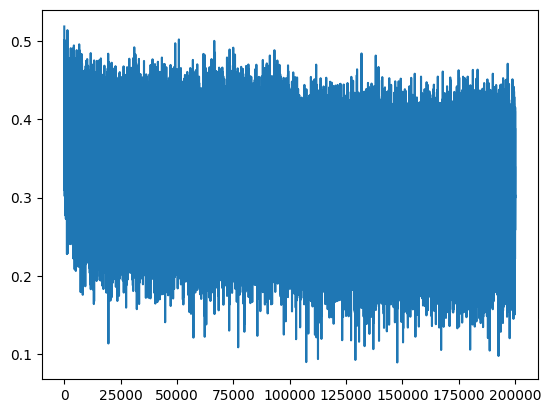

In [6]:
plt.plot(lossi);

## Batch Normalisation

In [42]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / ((n_embd * block_size)**0.5)) # Kamming init
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 # added to remove any random bias

# ----Parameters for Batch Norm Layer -------
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b1, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [43]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
  # =============== Batch normalisation Layer ====================
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = (hpreact - bnmeani) / bnstdi
  hpreact = bngain * hpreact + bnbias
  # ====================Layer over ===============================
 
  with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnmeani
     
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer -- for logits to be closer to zero need W2 to be closer to zero
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'loss -->{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break

loss -->      0/ 200000: 3.3085
loss -->  10000/ 200000: 1.8747
loss -->  20000/ 200000: 2.1623
loss -->  30000/ 200000: 2.2034
loss -->  40000/ 200000: 2.3872
loss -->  50000/ 200000: 1.9588
loss -->  60000/ 200000: 2.1058
loss -->  70000/ 200000: 2.0295
loss -->  80000/ 200000: 1.7769
loss -->  90000/ 200000: 1.9942
loss --> 100000/ 200000: 2.0768
loss --> 110000/ 200000: 2.3125
loss --> 120000/ 200000: 2.0579
loss --> 130000/ 200000: 1.9397
loss --> 140000/ 200000: 2.1347
loss --> 150000/ 200000: 2.1316
loss --> 160000/ 200000: 2.4168
loss --> 170000/ 200000: 2.1178
loss --> 180000/ 200000: 2.2730
loss --> 190000/ 200000: 2.4089


In [44]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  # ----------------BatchNorm------------
  hpreact = embcat @ W1 + b1
  hpreact = (hpreact - hpreact.mean(0, keepdim = True)) / (hpreact.std(0, keepdim=True))
  hpreact = bngain * hpreact + bnbias
  # ---------------Over------------------
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0666301250457764
val 2.107985734939575


### What if we want to test for an input. How to do that...batch norm calibiration

In [46]:
# Calibirating the batch norm at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1+b1
    
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)

# Eliminated this need by using the concept of bnmean_running which is accumulated at the every end of the training itself.
# We do not need to estimate as above

In [48]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  # ----------------BatchNorm------------
  hpreact = embcat @ W1 + b1
  hpreact = (hpreact - bnmean) / bnstd
  hpreact = bngain * hpreact + bnbias
  # ---------------Over------------------
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0666301250457764
val 2.1079814434051514


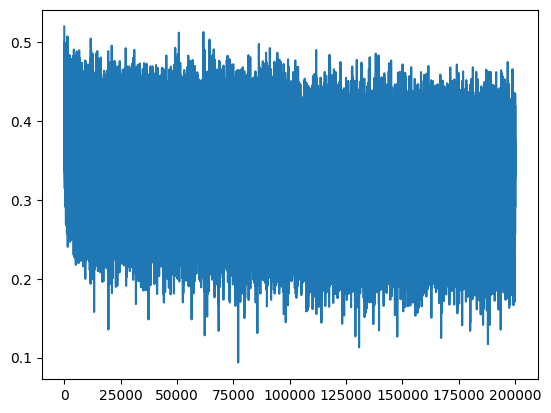

In [53]:
plt.plot(lossi);